In [1]:
# Start writing code here...
import pandas as pd
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

## Read in data of II trips

In [2]:
trips_ii = pd.read_csv('./Full Data1/trips_ii.csv',index_col=0)
trips_ii.reset_index(drop=True, inplace=True)

## Create geometry column

In [3]:
# creating a geometry column 
trips_ii_origin = trips_ii.copy()
trips_ii_destn = trips_ii.copy()
trips_ii_origin['Startlocation'] = list(zip(trips_ii_origin.StartLocLon, trips_ii_origin.StartLocLat))
trips_ii_origin['Startlocation'] = trips_ii_origin['Startlocation'].apply(Point)

trips_ii_destn['Endlocation'] = list(zip(trips_ii_destn.EndLocLon, trips_ii_destn.EndLocLat))
trips_ii_destn['Endlocation'] = trips_ii_destn['Endlocation'].apply(Point)

In [4]:
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf_ii_origin = gpd.GeoDataFrame(trips_ii_origin, crs=crs, geometry=list(trips_ii_origin['Startlocation']))

# Creating a Geographic data frame 
gdf_ii_destn = gpd.GeoDataFrame(trips_ii_destn, crs=crs, geometry=list(trips_ii_destn['Endlocation']))

## Separate each cluster into different dataframs

In [5]:
gb = gdf_ii_origin.groupby('StartCluster')    
clusters_origin = [gb.get_group(x) for x in gb.groups]
gb_destn = gdf_ii_destn.groupby('EndCluster') 
clusters_destn = [gb_destn.get_group(x) for x in gb_destn.groups]

# Origion Cluster Analysis

## Get the number of trips in each origion cluster

In [6]:
# display the number of trips in each cluster
_clusters = gdf_ii_origin.groupby('StartCluster',as_index=False).agg(tripcount = ('TripId','count'))
sorted_clusters_origin = _clusters.sort_values(by ='tripcount')
sorted_clusters_origin

,StartCluster,tripcount
22,22,433
25,25,977
2,2,2269
0,0,3661
9,9,3941
11,11,14081
15,15,15080
20,20,16725
7,7,20489
26,26,24682


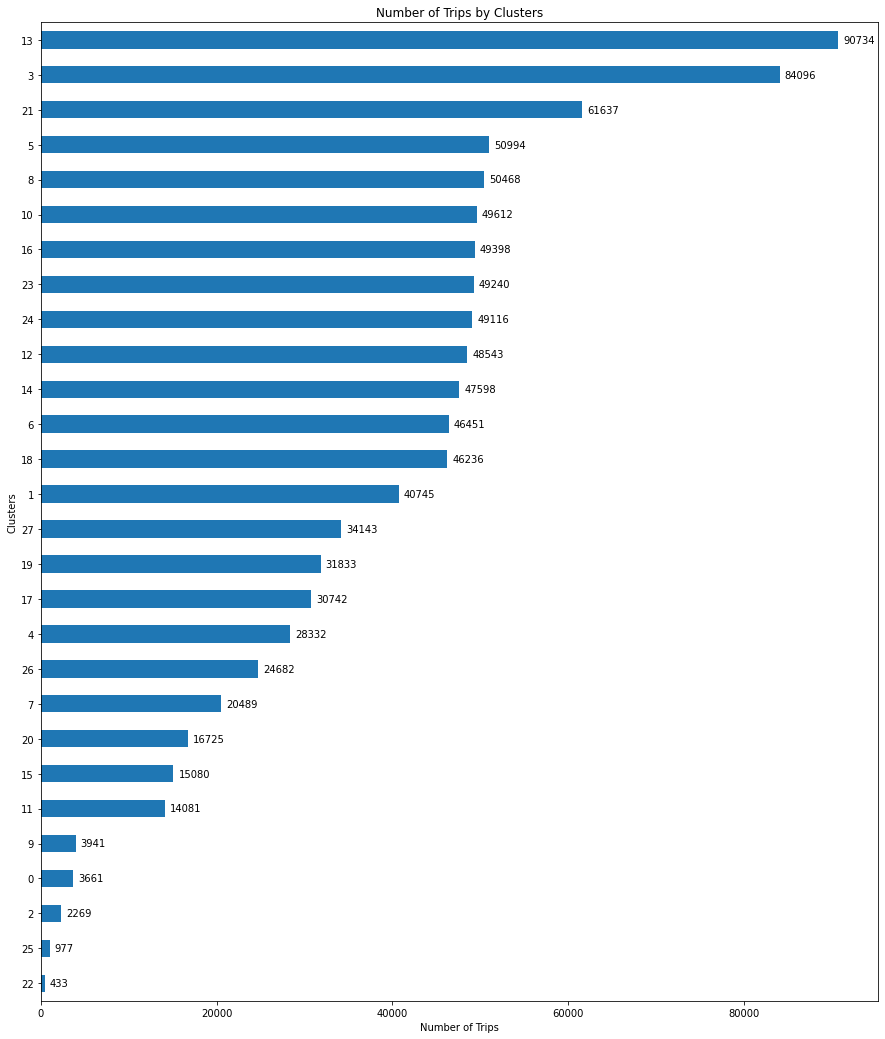

In [7]:
#plt.rcParams['figure.figsize'] = [12, 15]
plt.figure(figsize=(15,18))
# Plot the figure.
cluster = list(sorted_clusters_origin.index)
tripcount = sorted_clusters_origin['tripcount']
# Plot the figure.
ax = tripcount.plot(kind='barh')
ax.set_title('Number of Trips by Clusters')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Clusters')
ax.set_yticklabels(cluster)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:d}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

#plt.savefig("image.png")

## Get average trip time of each origin region

In [8]:
average_trip_time_origin = []
col_name = []
for i in range(0,28):
    name = str(i)
    col_name.append(name)

for gdf_origin in clusters_origin: 
    time_diff = gdf_origin
    time_diff['MST_end_datetime'] = pd.to_datetime(time_diff['MST_end_datetime'])
    time_diff['MST_start_datetime'] = pd.to_datetime(time_diff['MST_start_datetime'])

    time_diff['timediff_min'] = (time_diff.MST_end_datetime - time_diff.MST_start_datetime) / pd.Timedelta(minutes=1)
    ave = time_diff['timediff_min'].mean()
    average_trip_time_origin.append(ave)  

In [9]:
average_trip_time_origin = pd.DataFrame({"StartCluster":col_name,"triptime":average_trip_time_origin})
average_trip_time_origin = average_trip_time_origin.sort_values(by=['triptime'])
average_trip_time_origin

,StartCluster,triptime
8,8,9.379611
21,21,9.821888
13,13,9.880586
16,16,10.352824
18,18,10.393713
6,6,10.427768
4,4,10.652443
27,27,10.825766
14,14,10.923914
7,7,11.095251


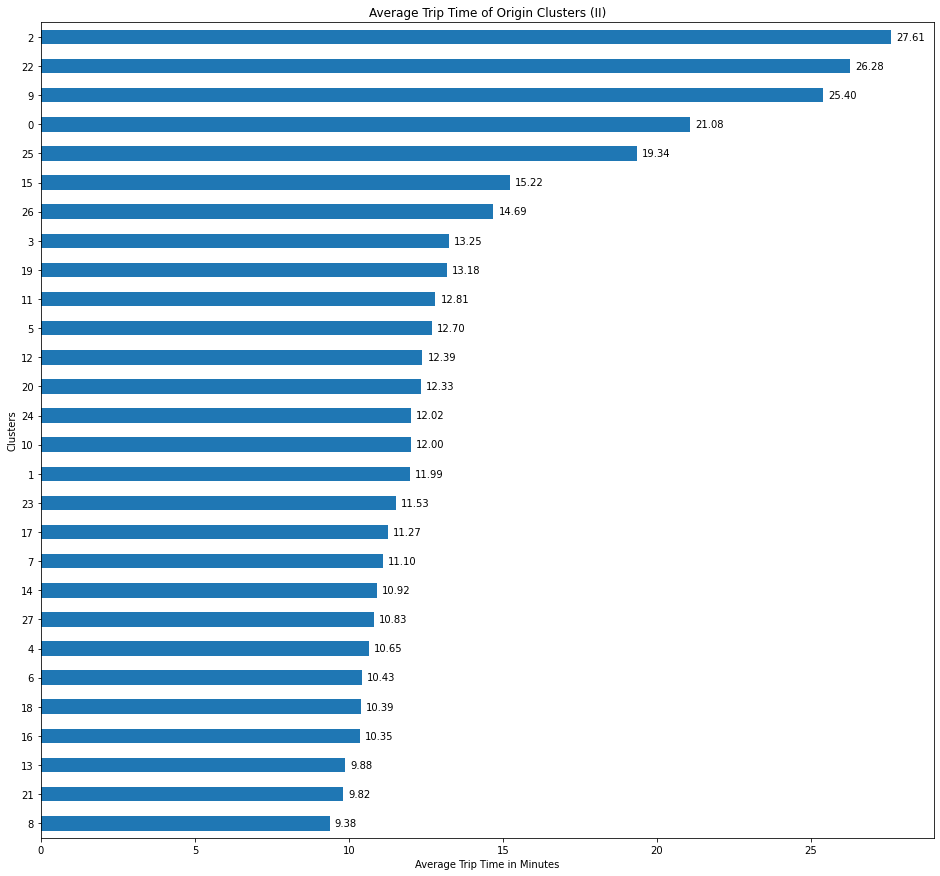

In [11]:
plt.figure(figsize=(16,15))
# Plot the figure.
cluster = list(average_trip_time_origin['StartCluster'])
# Plot the figure.
ax = average_trip_time_origin['triptime'].plot(kind='barh')
ax.set_title('Average Trip Time of Origin Clusters (II)')
ax.set_xlabel('Average Trip Time in Minutes')
ax.set_ylabel('Clusters')
ax.set_yticklabels(cluster)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.2f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

#plt.savefig("image.png")

## Create the bounding polygon of each cluster

In [13]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
polygons = []
for cluster in clusters_origin:
    points = list(zip(cluster['StartLocLon'],cluster['StartLocLat']))
    points = np.array([*points])
    hull = ConvexHull(points)
    points_l = []
    for simplex in hull.simplices:
        points_l.append(Point(points[simplex][0][0], points[simplex][0][1]))
        points_l.append(Point(points[simplex][1][0], points[simplex][1][1]))

    polygon_geom = Polygon([[p.x, p.y] for p in points_l]).convex_hull
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
    polygons.append(polygon)

## Draw polygons, gradient by the number of trips in each cluster

In [16]:
# convert ['StartCluster'] column to string 
sorted_clusters_origin['StartCluster'] = sorted_clusters_origin['StartCluster'].astype('str')

# create a geojson object from the polygons
geojson_poly = pd.DataFrame()
geojson_poly['StartCluster'] = sorted_clusters_origin['StartCluster']
geojson_poly['geometry'] = ''
for i in geojson_poly['StartCluster']:
    i = int(i)
    geojson_poly['geometry'].loc[i] = polygons[i]['geometry'].loc[0]
crs = {'init': 'epsg:4326'}
geojson_poly = gpd.GeoDataFrame(geojson_poly, crs=crs, geometry=list(geojson_poly['geometry']))
geojson_poly = geojson_poly.to_json()

In [20]:
# Draw the gradiented polygons on map 
import folium
m = folium.Map(location=[38, -104], zoom_start=8)
crs = {'init': 'epsg:4326'}
# capturing the return of folium.Choropleth()
cp = folium.Choropleth(
  geo_data=geojson_poly,
  name="choropleth",
  data=sorted_clusters_origin,
  columns=['StartCluster','tripcount'],
  key_on="feature.id",
  fill_color="YlGn",
  fill_opacity=0.7,
  line_opacity=0.2,
  legend_name="Number of Trips",
).add_to(m)

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    s['properties']['tripcount'] = str(sorted_clusters_origin['tripcount'].loc[int(s['id'])])

# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['StartCluster','tripcount']).add_to(cp.geojson)

folium.LayerControl().add_to(m)

m

## Draw polygons, gradient by the average trip time

In [21]:
# convert ['StartCluster'] column to string 
average_trip_time_origin['StartCluster'] = average_trip_time_origin['StartCluster']

# create a geojson object from the polygons
geojson_poly = pd.DataFrame()
geojson_poly['StartCluster'] = average_trip_time_origin['StartCluster']
geojson_poly['geometry'] = ''
for i in geojson_poly['StartCluster']:
    i = int(i)
    geojson_poly['geometry'].loc[i] = polygons[i]['geometry'].loc[0]
crs = {'init': 'epsg:4326'}
geojson_poly = gpd.GeoDataFrame(geojson_poly, crs=crs, geometry=list(geojson_poly['geometry']))
geojson_poly = geojson_poly.to_json()

In [23]:
# Draw the gradiented polygons on map 
import folium
m = folium.Map(location=[38, -104], zoom_start=8)
crs = {'init': 'epsg:4326'}
# capturing the return of folium.Choropleth()
cp = folium.Choropleth(
  geo_data=geojson_poly,
  name="choropleth",
  data=average_trip_time_origin,
  columns=['StartCluster','triptime'],
  key_on="feature.id",
  fill_color="YlGn",
  fill_opacity=0.7,
  line_opacity=0.2,
  legend_name="Average Trip Time",
).add_to(m)

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    s['properties']['triptime'] = str(average_trip_time_origin['triptime'].loc[int(s['id'])])

# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['StartCluster','triptime']).add_to(cp.geojson)

folium.LayerControl().add_to(m)

m